# Data exploration notebook

In [ ]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data loading

In [3]:
print("Loading IMDB dataset...")
dataset = load_dataset("imdb")

print(f"\nDataset structure:")
print(dataset)

train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Loading IMDB dataset...


Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 1248223.03 examples/s]



Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Train shape: (25000, 2)
Test shape: (25000, 2)


## 2. Basic exploration


DATA EXPLORATION

First rows:
                                                text  label  text_length  \
0  I rented I AM CURIOUS-YELLOW from my video sto...      0         1640   
1  "I Am Curious: Yellow" is a risible and preten...      0         1294   
2  If only to avoid making this type of film in t...      0          528   
3  This film was probably inspired by Godard's Ma...      0          706   
4  Oh, brother...after hearing about this ridicul...      0         1814   

   word_count  
0         288  
1         214  
2          93  
3         118  
4         311  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         25000 non-null  object
 1   label        25000 non-null  int64 
 2   text_length  25000 non-null  int64 
 3   word_count   25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4

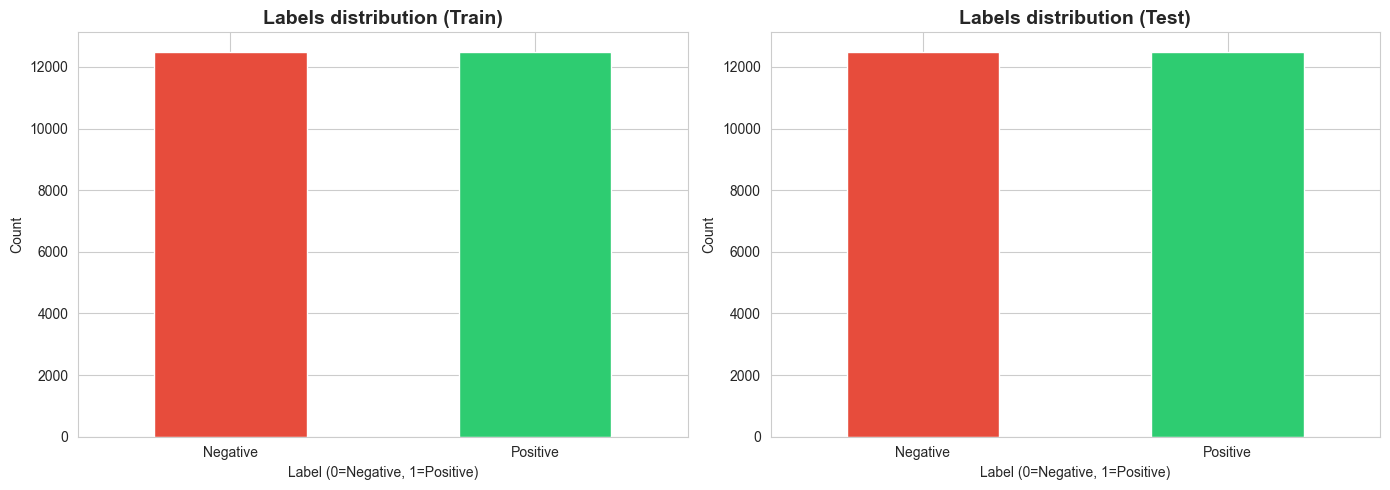

In [17]:
print("\n" + "="*80)
print("DATA EXPLORATION")
print("="*80)

print("\nFirst rows:")
print(train_df.head())

print("\nDataset info:")
print(train_df.info())

print("\nDescriptive statistics:")
print(train_df.describe())

print("\nLabel distribution:")
print(train_df['label'].value_counts())
print(f"Proportion: {train_df['label'].value_counts(normalize=True)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_df['label'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Labels distribution (Train)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label (0=Negative, 1=Positive)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Negative', 'Positive'], rotation=0)

test_df['label'].value_counts().plot(kind='bar', ax=axes[1], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('Labels distribution (Test)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Label (0=Negative, 1=Positive)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Negative', 'Positive'], rotation=0)

plt.tight_layout()
plt.show()

## 3. Text analysis


TEXT ANALYSIS

Statistics on text length:
       text_length    word_count
count  25000.00000  25000.000000
mean    1325.06964    233.787200
std     1003.13367    173.733032
min       52.00000     10.000000
25%      702.00000    127.000000
50%      979.00000    174.000000
75%     1614.00000    284.000000
max    13704.00000   2470.000000


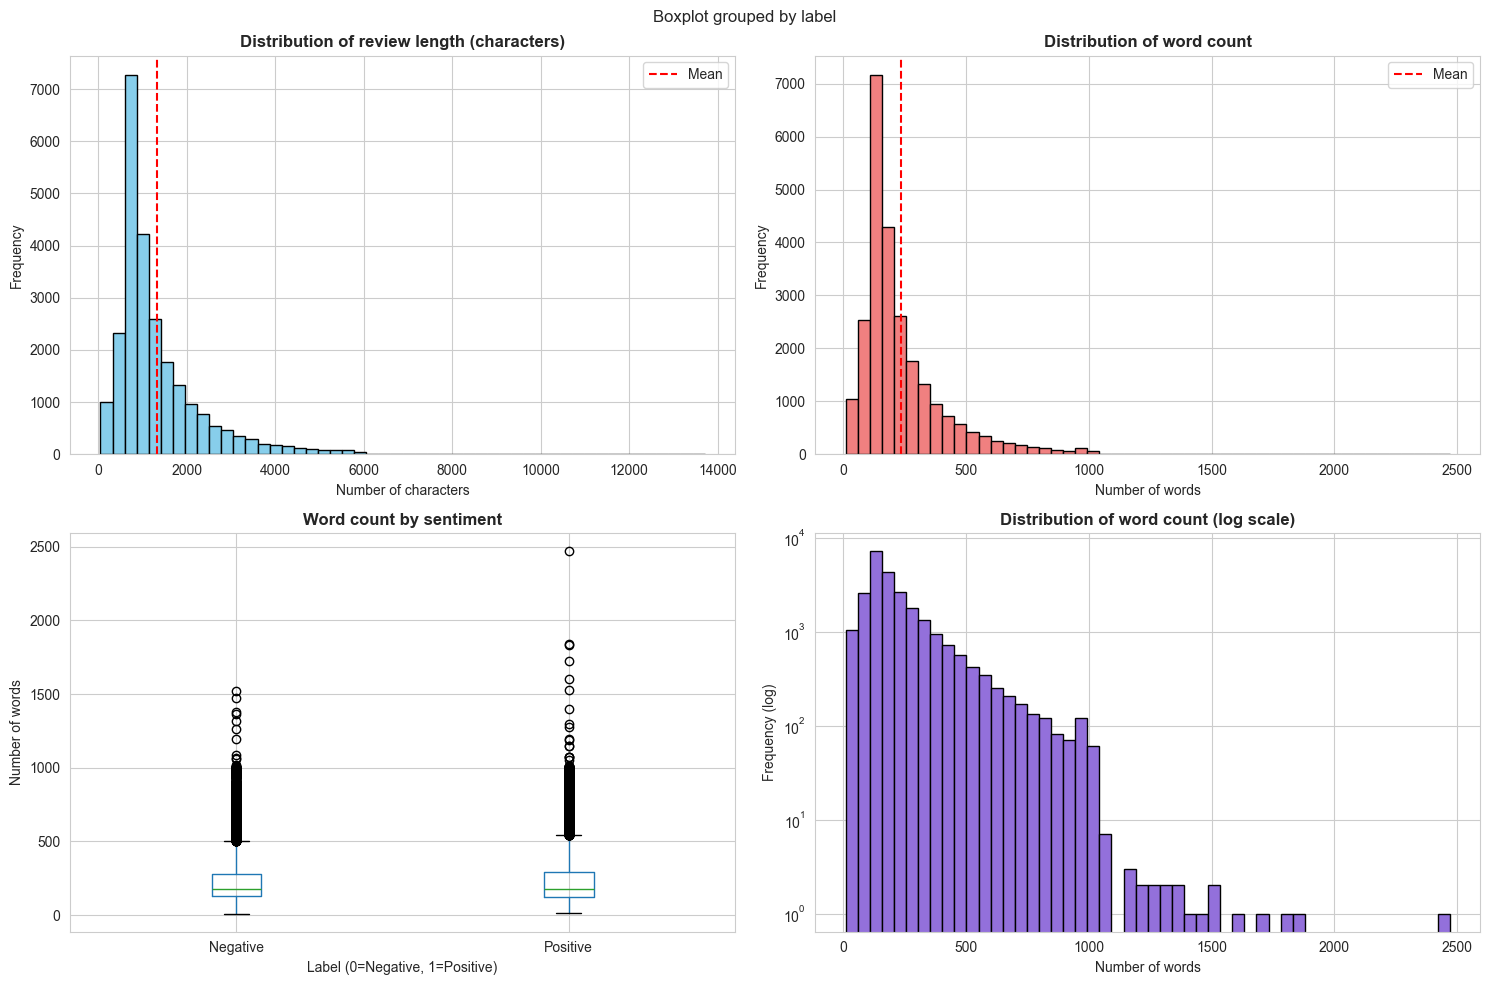

In [16]:
# Review length
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

print("\n" + "="*80)
print("TEXT ANALYSIS")
print("="*80)

print("\nStatistics on text length:")
print(train_df[['text_length', 'word_count']].describe())

# Visualization of lengths
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
axes[0, 0].hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of review length (characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_df['text_length'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Word count distribution
axes[0, 1].hist(train_df['word_count'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of word count', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(train_df['word_count'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].legend()

# Comparison by sentiment
train_df.boxplot(column='word_count', by='label', ax=axes[1, 0])
axes[1, 0].set_title('Word count by sentiment', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Label (0=Negative, 1=Positive)')
axes[1, 0].set_ylabel('Number of words')
plt.sca(axes[1, 0])
plt.xticks([1, 2], ['Negative', 'Positive'])

# Log-scale distribution
axes[1, 1].hist(train_df['word_count'], bins=50, color='mediumpurple', edgecolor='black', log=True)
axes[1, 1].set_title('Distribution of word count (log scale)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of words')
axes[1, 1].set_ylabel('Frequency (log)')

plt.tight_layout()
plt.show()


## 4. Review examples

In [20]:
print("\n" + "="*80)
print("REVIEW EXAMPLES")
print("="*80)

print("\n--- POSITIVE REVIEW (short) ---")
positive_short = train_df[(train_df['label'] == 1) & (train_df['word_count'] < 70)].iloc[0]
print(f"Length: {positive_short['word_count']} words")
print(positive_short['text'][:500])

print("\n--- NEGATIVE REVIEW (short) ---")
negative_short = train_df[(train_df['label'] == 0) & (train_df['word_count'] < 70)].iloc[0]
print(f"Length: {negative_short['word_count']} words")
print(negative_short['text'][:500])


REVIEW EXAMPLES

--- POSITIVE REVIEW (short) ---
Length: 57 words
As much as the movie was good, i have nothing more to say about it than what was said already. all i wanted is to point the fact that the movie isnt from Sweden but from Denemark. Maybe I wrong and in that case i'll be happy to know my mistakes so take the and notify me.

--- NEGATIVE REVIEW (short) ---
Length: 69 words
I think I will make a movie next weekend. Oh wait, I'm working..oh I'm sure I can fit it in. It looks like whoever made this film fit it in. I hope the makers of this crap have day jobs because this film sucked!!! It looks like someones home movie and I don't think more than $100 was spent making it!!! Total crap!!! Who let's this stuff be released?!?!?!


## 5. Basic vocabulary analysis

In [21]:
print("\n" + "="*80)
print("VOCABULARY ANALYSIS")
print("="*80)

def get_word_freq(texts, n=20):
    """Get the n most frequent words"""
    all_words = ' '.join(texts).lower()
    # Clean a bit
    all_words = re.sub(r'[^\w\s]', '', all_words)
    words = all_words.split()
    return Counter(words).most_common(n)

# Most frequent words by sentiment
positive_reviews = train_df[train_df['label'] == 1]['text']
negative_reviews = train_df[train_df['label'] == 0]['text']

print("\nTop 20 words in POSITIVE reviews:")
pos_words = get_word_freq(positive_reviews)
for word, count in pos_words:
    print(f"  {word}: {count}")

print("\nTop 20 words in NEGATIVE reviews:")
neg_words = get_word_freq(negative_reviews)
for word, count in neg_words:
    print(f"  {word}: {count}")


VOCABULARY ANALYSIS

Top 20 words in POSITIVE reviews:
  the: 172280
  and: 88785
  a: 83136
  of: 76586
  to: 66391
  is: 57025
  in: 49708
  it: 38437
  i: 35573
  this: 34739
  that: 34051
  br: 27530
  as: 26157
  with: 23139
  for: 22273
  was: 21833
  but: 20415
  film: 19593
  movie: 18140
  his: 17152

Top 20 words in NEGATIVE reviews:
  the: 162426
  a: 78805
  and: 73442
  of: 68740
  to: 68651
  is: 49827
  in: 43320
  this: 40451
  i: 40144
  it: 38664
  that: 35300
  br: 29608
  was: 26175
  movie: 23668
  for: 21691
  but: 21326
  with: 20732
  as: 20504
  film: 17861
  on: 16859


## 6. Training preparation

In [26]:
print("\n" + "="*80)
print("TRAINING RECOMMENDATIONS")
print("="*80)

print(f"""
Key observations:
- Balanced dataset: {train_df['label'].value_counts().values[0]} samples per class
- Average length: {train_df['word_count'].mean():.0f} words
- Median length: {train_df['word_count'].median():.0f} words
- Reviews vary greatly in length (from a few words to several thousand)

Training strategies:
1. SIMPLE BASELINE (Logistic Regression + TF-IDF):
   - Fast to train
   - max_features=5000-10000
   - Good starting point for MLOps pipeline

2. ADVANCED MODEL (optional later):
   - DistilBERT (lightweight and efficient)
   - Fine-tuning for 2-3 epochs

Preprocessing:
- Lowercase
- Remove HTML tags (<br /> visible in reviews)
- Limit max_length to avoid overly long reviews
- Train/Val split: 80/20
""")

# Save a small sample for testing
sample_df = train_df.sample(n=100, random_state=42)
sample_df[['text', 'label']].to_csv('../data/processed/sample_data.csv', index=False)
print("\nSample of 100 reviews saved to data/processed/sample_data.csv")


TRAINING RECOMMENDATIONS

Key observations:
- Balanced dataset: 12500 samples per class
- Average length: 234 words
- Median length: 174 words
- Reviews vary greatly in length (from a few words to several thousand)

Training strategies:
1. SIMPLE BASELINE (Logistic Regression + TF-IDF):
   - Fast to train
   - max_features=5000-10000
   - Good starting point for MLOps pipeline

2. ADVANCED MODEL (optional later):
   - DistilBERT (lightweight and efficient)
   - Fine-tuning for 2-3 epochs

Preprocessing:
- Lowercase
- Remove HTML tags (<br /> visible in reviews)
- Limit max_length to avoid overly long reviews
- Train/Val split: 80/20


Sample of 100 reviews saved to data/processed/sample_data.csv
